In [15]:
import os 
import torch
import shutil
import numpy as np
from pathlib import Path
from glob import glob
from PIL import Image
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms as T
torch.manual_seed(42)

## Custom Datasets

In [16]:
class MyDataset(Dataset):
    def __init__(self, path, transformations=None):
        #Apply img transformations
        self.transformations = transformations
        #Load all images in a path
        self.img_paths = [im_path for im_path in sorted(glob(f"{path}/*/*"))]
        #Dictionaries and counters for classes and count per class
        self.class_names = {}
        self.class_counts = {}
        count = 0

        for idx, img_path in enumerate(self.img_paths):
            #Get the class name
            class_name = self.get_class(img_path)
            #Check if the class exist already and if not appends it to the class name dict
            if class_name not in self.class_names:
                self.class_names[class_name] = count
                self.class_counts[class_name] = 1
                count += 1
            #If it exist, increase the counter for that class
            else:
                self.class_counts[class_name] += 1

    #Function to get the real label of an img
    def get_class(self, path) -> str:
        """Return the name of the class based on its path"""
        return os.path.dirname(path).split("/")[-1]
    
    def __len__(self):
        return len(self.img_paths)
    
    #Obtain 1 image and its label from te ds
    def __getitem__(self, idx: int):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.class_names[self.get_class(img_path)]

        #If there are tarnsformation, apply it to return the image with them.
        if self.transformations is not None:
            image = self.transformations(image)
        return image, label
        


In [17]:
dataset = MyDataset("/home/edu_pc/Projects/Aer_City_Img_Classifier/dataset/")
print(len(dataset))

a,b = dataset[0]



8000


## Dataloaders

In [68]:
from torch.utils.data import Subset

def create_dataloaders_random(path, transformations, batch_size, split: list = [0.9, 0.05, 0.05], num_workers: int = 4):
    """Organize and create the dataloaders for train, valid and test using our datset objet. The split is RANDOM! """
    dataset = MyDataset(path = path, transformations=transformations)
    #Calculate the len for each split (train, valid, test)
    dataset_len = len(dataset)
    train_len = int(dataset_len * split[0])
    val_len = int(dataset_len * split[1])
    test_len = int(dataset_len * split[2])

    #Create the splits 
    tr_ds, val_ds, test_ds = random_split(dataset, lengths=[train_len, val_len, test_len])

    #Create the dataloaders
    tr_dl = DataLoader(dataset=tr_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers) 
    #Avoid shuffle for replicability in both val and test 
    val_dl = DataLoader(dataset=val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    #test images are evaluated 1 by 1  
    test_dl = DataLoader(dataset=test_ds, batch_size=1, shuffle=False, num_workers=num_workers)  

    #Return dataloaders for each split andthe class_names with its IDs (keys are the name, value the ID)
    return tr_dl, val_dl, test_dl, dataset.class_names


def stratified_dataset_split(dataset: Dataset, split: list = [0.9, 0.05, 0.05]):
    """Create the stratified subsets. Mantain class proportions """
    #We want to create a dictionary of image indexes for each class
    class_idxs = {}
    for idx, (_, label) in enumerate(dataset):
        if label not in class_idxs:
            class_idxs[label] = []
        class_idxs[label].append(idx)

    #Create the splits for each clas
    train_idxs, val_idxs, test_idxs = [], [], []
    for label, idxs in class_idxs.items():
        n_total = len(idxs)
        n_train = int(n_total * split[0])
        n_val = int(n_total * split[1])
        n_test = int(n_total * split[2])

        #Divide the indexes (idxs is a list of indexes) of each class in our list of indexes per split
        train_idxs.extend(idxs[:n_train])
        val_idxs.extend(idxs[n_train:n_train + n_val])
        test_idxs.extend(idxs[n_train + n_val:])

    #Create the subsets using torch utils Subset
    tr_ds = Subset(dataset, train_idxs)
    val_ds = Subset(dataset, val_idxs)
    test_ds = Subset(dataset, test_idxs)

    return tr_ds, val_ds, test_ds

    


def create_stratified_dataloaders(path, transformations, batch_size, split: list = [0.9, 0.05, 0.05], num_workers: int = 4):
    dataset = MyDataset(path=path, transformations=transformations)

    #stratified_dataset_split will return subsets of datasets acording our factors
    tr_ds, val_ds, test_ds = stratified_dataset_split(dataset, split)

    #Create the stratified dataloaders
    tr_dl = DataLoader(dataset=tr_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_dl = DataLoader(dataset=val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_dl = DataLoader(dataset=test_ds, batch_size=1, shuffle=False, num_workers=num_workers)

    #Return dataloaders and classes
    return tr_dl, val_dl, test_dl, dataset.class_names

## Initialization dataset and dataloaders for our project

In [69]:
ds_path = "dataset"

#Normalization parameters per channel
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
resize = 224

#Define the transformations using transforms utils
    #Resize to 224x224
    #Tranform to tensor
    #Normalize according typical values of ConvNext, ResNet and so
transforms = T.Compose([
    T.Resize((resize,resize)),
    T.ToTensor(),
    T.Normalize(mean = mean, std = std)]
)

#Create the dataloaders using our function
tr_dl, val_dl, test_dl, classes = create_stratified_dataloaders(path=ds_path, transformations=transforms, batch_size=32)


In [70]:
#Check the batches per dataloader
print(len(tr_dl)); print(len(val_dl)); print(len(test_dl)); print(classes)

225
13
400
{'Bridge': 0, 'Commercial': 1, 'Industrial': 2, 'Intersection': 3, 'Landmark': 4, 'Park': 5, 'Parking': 6, 'Playground': 7, 'Residential': 8, 'Stadium': 9}


The numbers are correct. We have 400 batches in the test_dl because we specified batch size of 1

## Data visualization

In [ ]:
from matplotlib import pyplot as pt
import random

def tensor2image(tensor, img_type = "rgb"):
    #Tensor in pytorch for images are expressed in [C x H x W]
    #We need to transform the tensors back to images
    gray_transforms = T.Compose([
        #First we invert the std
        T.Normalize(mean = [0.], std = [1/0.5]),
        #Then we invert the mean
        T.Normalize(mean = [-0.5], std = [1])
    ])

    rgb_transforms = T.Compose([
        #First we invert the std
        T.Normalize(mean = [0.,0.,0.], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
        #Then we invert the mean (sum the mean, because is the opposite in the normalization, substract)
        T.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ])
    ])

    invert_transforms = rgb_transforms if img_type.lower() == "rgb" else gray_transforms
    #invert_transform --> applies inverse transformations to the tensored image and multiply by 255 to get the px value
    #.detach() --> Disconnect the tensor from calculating gradients
    #.squeeze() --> Deletes dimensions with 1, for instance in gray images
    #.cpu() --> move the tensor to the CPU if it was located in the GPU
    #.permut(1,2,0) --> changes axes of the tesnor (C, H, W,) for the ones expected by matplotlib (H, W, C)
    #.numpy() --> converts the array to a numpy array
    #.astype(np.uint8) --> Converts the values to the 8bit format of images
    #The result of all of this is a an image ready to be visualized by matplotlib
    return (invert_transforms(tensor) * 255).detach().squeeze().cpu().permute(1,2,0).numpy().astype(np.uint8)
    
    #return (invTrans(t) * 255).detach().squeeze().cpu().permute(1,2,0).numpy().astype(np.uint8) if t_type == "gray" else (invTrans(t) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8)


def plot_images(dataset, n_imgs, rows, img_type: str = None, class_names = None):
    #Check if the input has a img_type otherwise rise an assertError
    assert img_type.lower() in ["rgb", "gray"], "Missing image type (rgb or gray)"
    #Select the color map for the type of image
    if img_type == "rgb":
        #If the images is RGB select viridis color map
        cmap = "viridis"
    else:
        cmap = img_type
    #Create the figure where the images will be displayed
    pt.figure(figsize=(20,10))
    #Create a list of random indexes of images from the dataset and input "n_imgs"
    rndm_idx = [random.randint(0, len(dataset) -1) for _ in range(n_imgs)]
    
    for i, idx in enumerate(rndm_idx):
        img_tensor, label = dataset[idx]
        #Create one image inside figure (1 position inside the grid)
        pt.subplot(rows, n_imgs // rows, i + 1)
        if img_type:
            pt.imshow(tensor2image(tensor=img_tensor, img_type=img_type), cmap=cmap)
        #If there is no type specified, use the default value which is "rgb"
        else:
            pt.imshow(tensor2image(tensor=img_tensor))
        pt.axis('off')
        if class_names is not None:
            #If class_name is defined, use it
            pt.title(f"True L --> {class_names[int(label)]}")
        else:
            #Else, use the true label
            pt.title(f"True L --> {label}")



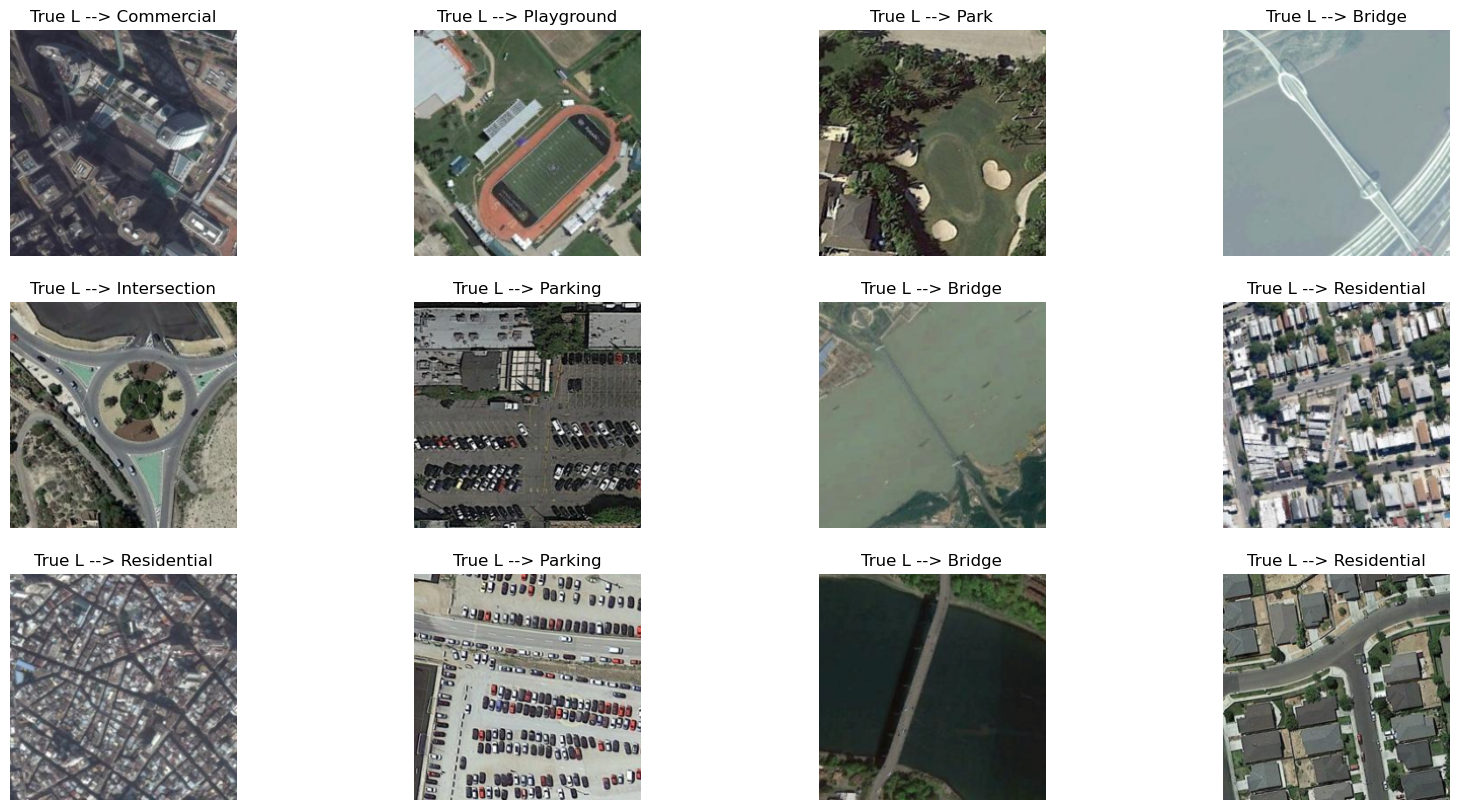

In [33]:
plot_images(tr_dl.dataset, 12, 3, "rgb", list(classes.keys()))

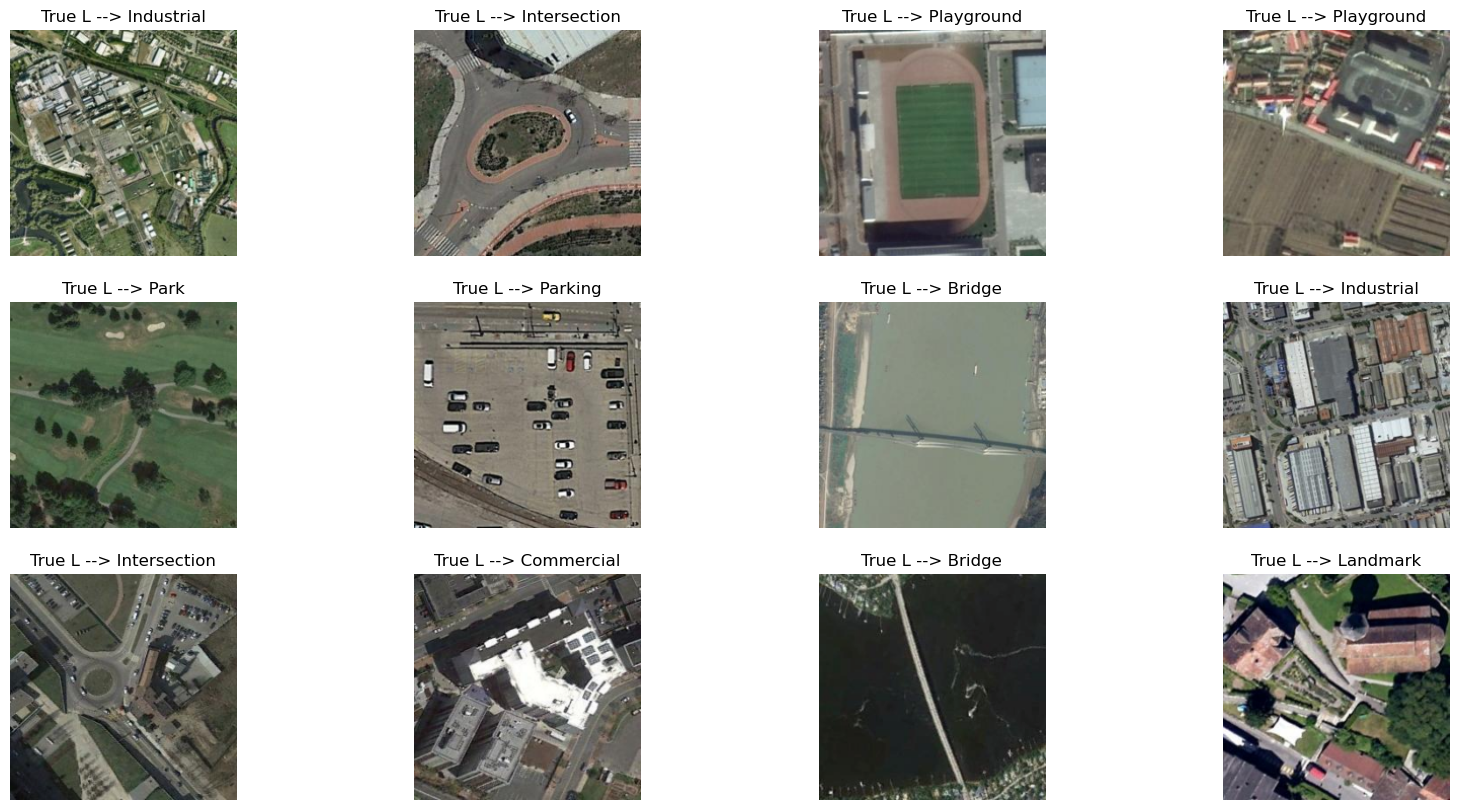

In [34]:
plot_images(tr_dl.dataset, 12, 3, "rgb", list(classes.keys()))

## Simple EDA: Class distributions

In [ ]:
def class_distribution(dataset_path: str, transformations: T.Compose):
    """ Func that, given a dataset and transformations, plots the distributions of the classes"""
    dataset = MyDataset(path=dataset_path, transformations=transformations)
    
    #Graphic parameters for text
    width = 0.8
    text_width = 0.06
    text_height = 2
    class_counts = dataset.class_counts
    class_names = list(dataset.class_names.keys())
    counts = list(class_counts.values())

    fig, ax = pt.subplots(figsize= (20,10))
    #Return evenly spaced values from a range, for the bar graph
    idxs = np.arange(len(counts))
    #Create the bars
    ax.bar(idxs, counts, width, color="blue")

    #Graphic config
    # Set axis X title
    ax.set_xlabel("Class names", color=("black"))
    # Set the ticks in axis X and its labels
    ax.set(xticks=idxs, xticklabels=class_names)
    # Set a parameter rotation for the axis X labels
    ax.tick_params(axis="x", rotation=45)
    #Set axis Y label
    ax.set_ylabel("Frequency", color="black")
    #Set title for the graph
    ax.set_title("Classes distribution")
    
    #Adds a text over each column
    for i, val in enumerate(counts):
        ax.text(i - text_width, val + text_height, str(val), color="blue")


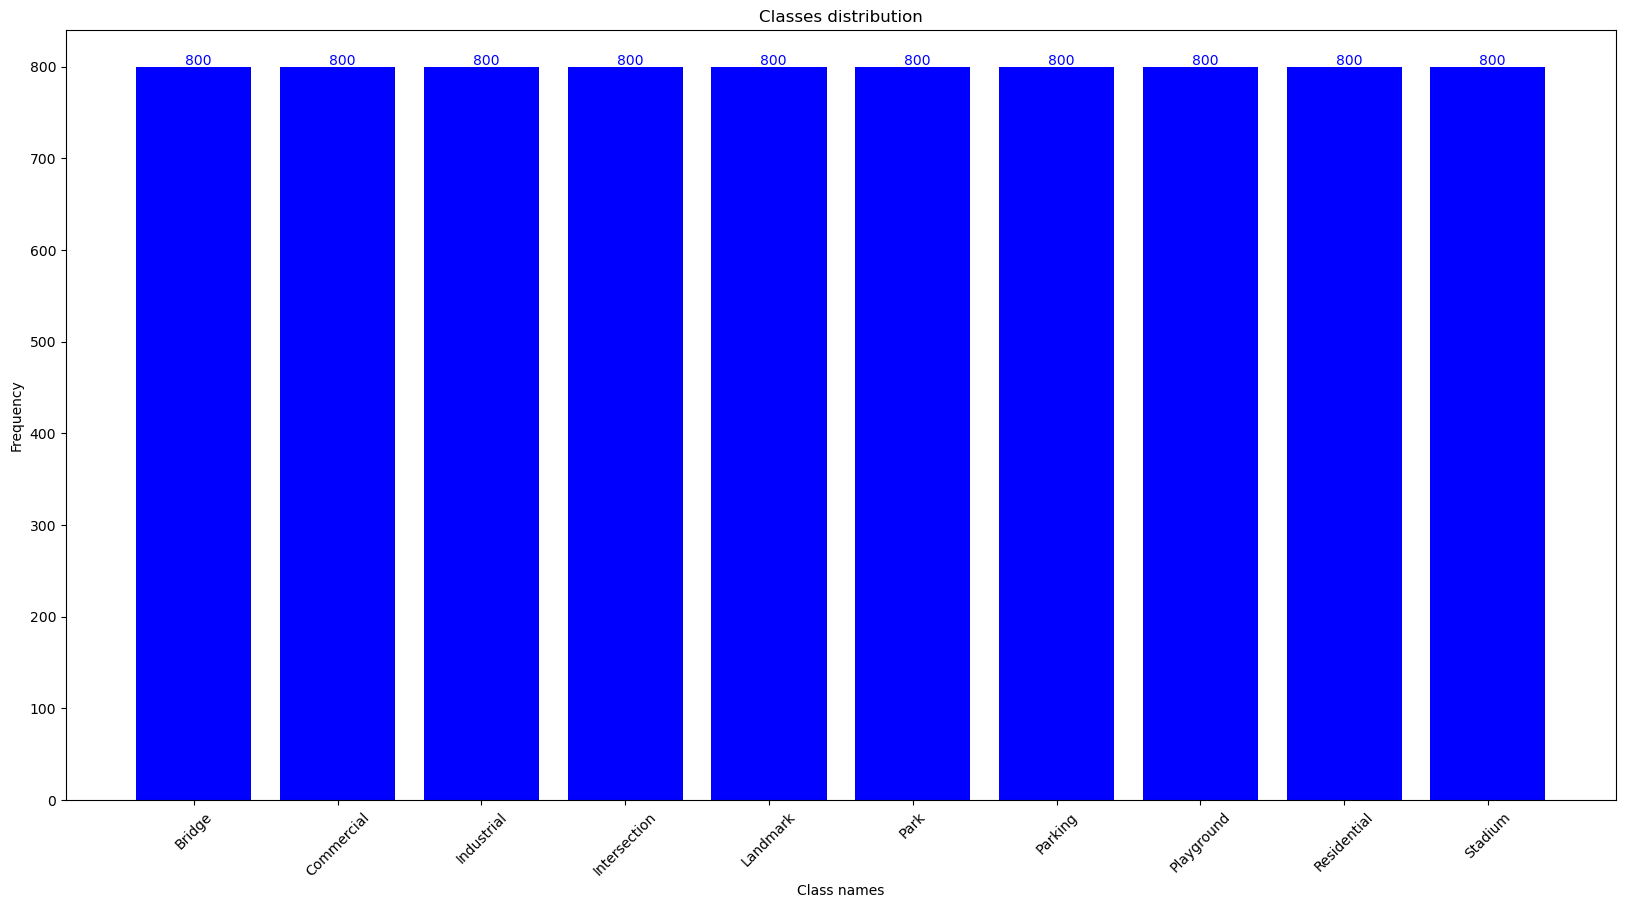

In [64]:
class_distribution(ds_path, transformations=transforms)

Classes are balanced across the dataset. This is good, however in order to mantain class proportions we craeted a stratified dataloaders, which take into consideration the proportios per class and mantains the same proportions for the train, val and test dataloaders.

## Model import and training using PyTorch and evaluating using TensorBoard

In [ ]:
#pip install tensorboard

57793.25s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 75.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 70.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import timm
from tqdm.notebook import tqdm
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import precision_score, recall_score 
from torchvision.utils import make_grid #For image visualization in TensorBoard

#Initialize TensorBoard
writer = SummaryWriter("logs/experiment2") #Folder where to save logs

#Import pretrained model
model = timm.create_model("convnext_tiny", pretrained=True, num_classes=len(classes))

#Create the training setup for our transfer learning
def setup_train(model):
    """Easy way to create a setup environment given a model"""
    return model.to("cuda").train(), 7, "cuda", torch.nn.CrossEntropyLoss(), torch.optim.SGD(params=model.parameters(), lr=3e-4)
    #Put the model in train() behaviour
    #7 --> epochs
    #"cuda" --> str pointing to cuda device
    #CrossEntropy as the loss function
    #SGD as the optimizer with its parameters

#Function to move the data to the specified device
def move2device(batch, device):
    """Little function to move batches from CPU to GPU for calcs"""
    return batch[0].to(device), batch[1].to(device)

def calculate_losses(model, images, labels, loss_fn, epoch_loss, epoch_acc):
    """Calculate the losses and keep track of them per epoch"""
    #Generate predictions
    preds = model(images)
    #Calculate loss
    loss = loss_fn(preds, labels)
    #Updates the total loss and the accumulated accuracy
    return loss, epoch_loss + loss.item(), epoch_acc + (torch.argmax(preds, dim=1) == labels).sum().item()

def calculate_batch_PR(preds, labels):
    """Function to track precision and recall for validation batches"""
    preds_classes = torch.argmax(preds, dim=1).cpu().numpy()
    true_labels = labels.cpu().numpy()
    precision = precision_score(true_labels, preds_classes, average="weighted")
    recall = recall_score(true_labels, preds_classes, average="weighted")
    return precision, recall


##Training cycle
#Define the setup features
model, epochs, device, loss_fn, optimizer = setup_train(model)
best_loss = float("inf")

for epoch in range(epochs):
    epoch_loss, epoch_acc = 0, 0
    model.train() #Put the model into training state
    for i, batch in tqdm(enumerate(tr_dl)):
        imgs, lbls = move2device(batch, device)
        loss, epoch_loss, epoch_acc = calculate_losses(model, imgs, lbls, loss_fn, epoch_loss, epoch_acc)
        #Put the grads to 0
        optimizer.zero_grad()
        #Calculate grads
        loss.backward()
        #Optimizer do an step using those grads
        optimizer.step()
    
    #Register training metrics into TensorBoard
    #Mean loss per training batch
    tr_loss_to_track = epoch_loss / len(tr_dl)
    #Mean acc. per epoch
    tr_acc_to_track = epoch_acc / len(tr_dl.dataset)
    writer.add_scalar("Loss/Train", tr_loss_to_track, epoch)
    writer.add_scalar("Accuracy/Train", tr_acc_to_track, epoch)

    print(f"{epoch + 1}-epoch train loss: {tr_loss_to_track:.3f}, accuracy: {tr_acc_to_track:.3f}")


#Validation cycle
    val_epoch_loss, val_epoch_acc = 0, 0
    val_epoch_precision, val_epoch_recall = 0, 0
    model.eval()
    #During evaluation we do not calculate gradients
    with torch.no_grad():
        for i, batch in tqdm(enumerate(val_dl)):
            imgs, lbls = move2device(batch, device)
            preds = model(imgs)
            loss = loss_fn(preds, lbls)
            val_epoch_loss += loss.item()
            #From preds (for each image has a tensor of 10 logits), get the total of corrects predictions
            val_epoch_acc += (torch.argmax(preds, dim=1) == lbls).sum().item()

            #Calculate precision and recall for each val batch and accumulate
            precision, recall = calculate_batch_PR(preds, lbls)
            val_epoch_precision += precision
            val_epoch_recall += recall

            #Save images from the first batch only, as samples
            if i == 0:
                grid = make_grid(imgs[0:8].cpu(), nrow=2, normalize=True)
                writer.add_image(f"Validation examples/Epoch {epoch+1}", grid, epoch)
                writer.add_text(f"Predictions/Epoch {epoch+1}",
                                f"Predicted: {torch.argmax(preds[:8], dim=1).cpu().numpy()}",
                                f"Actual: {lbls[:8].cpu().numpy(), epoch}"
                                )

    #Register training metrics into TensorBoard
    #Mean loss per batch
    val_loss_to_track = val_epoch_loss / len(val_dl) # len(val_dl) is the total number of batches
    #Mean accuracy of the val dataset
    val_acc_to_track = val_epoch_acc / len(val_dl.dataset) #The reason we use dataset is because it is calculated per image
    #Mean precision and recall
    val_precision_to_track = val_epoch_precision / len(val_dl)
    val_recall_to_track = val_epoch_recall / len(val_dl)
    #Write and register the metrics
    writer.add_scalar("Loss/Validation", val_loss_to_track, epoch)
    writer.add_scalar("Accuracy/Validation", val_acc_to_track, epoch)
    writer.add_scalar("Precision/Validation", val_precision_to_track)
    writer.add_scalar("Recall/Validation", val_recall_to_track)


#Save the best model
if val_loss_to_track < best_loss:
    os.makedirs("saved_models", exist_ok=True)
    best_loss = val_loss_to_track
    torch.save(model.state_dict(), "saved_models/exp2_best_model.pth")
    
writer.close()

